In [ ]:
%pip install -U qiskit-ibm-runtime
%pip install -U qiskit-aer
%pip install -U qiskit-transpiler-service
%pip install -U pylatexenc

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [3]:
from math import gcd
from fractions import Fraction
from numpy.random import randint

In [5]:
from google.colab import userdata
api_key = userdata.get('IBM_API_KEY')

service = QiskitRuntimeService(
    channel='ibm_quantum_platform',
    instance='my_instance',
    token=api_key,
)

backend= service.backend('ibm_brisbane')

In [6]:
sampler= Sampler(backend)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=0)
sim= AerSimulator()

In [ ]:
#QFT
#Quantum Fourier Transform (QFT) is the quantum version of the classical Discrete Fourier Transform (DFT)
#QFT transforms a quantum state into a superposition where each basis state encodes a Fourier component
#This implies that it's a unitary map where each amplitude is Fourier-transformed
#QFT enables us to extract periodicity
#QFT turns periodicity in the computational basis into amplitude peaks
#QFT can be approximated by truncating small-angle rotations to reduce circuit depth(important for noisy devices)

In [8]:
#QFT Implementation
#The .cp in the code stands for a Controlled-Phase gate
#qc.cp(theta, control_qubit, target_qubit) applies a phase rotation of angle theta to the target_qubit
#Here, j is the control qubit and i is the target qubit

def qft(n):
  qc = QuantumCircuit(n)

  for i in range(n):
      qc.h(i)
      for j in range(i+1, n):
          qc.cp(np.pi / (2 ** (j - i)), j, i)

    #swap qubits to reverse order
  for i in range(n // 2):
      qc.swap(i, n - i - 1)

  qc.name = "QFT"
  return qc

In [9]:
#IQFT
#The Inverse Quantum Fourier Transform is the reverse operation of the QFT
#QFT maps a quantum state into the frequency domain and IQFT brings it back to the original computational basis
#IQFT applies the complex conjugate of the QFT matrix. So all the exponents become negative

In [10]:
#IQFT Implementation

def iqft(n):
    qc= QuantumCircuit(n)

    #opposite of QFT
    for i in reversed(range(n)):
        for j in reversed(range(i + 1, n)):
            qc.cp(-np.pi / (2 ** (j - i)), j, i)
        qc.h(i)

    #swap qubits to reverse order
    for i in range(n // 2):
        qc.swap(i, n - i - 1)

    qc.name= "IQFT"
    return qc

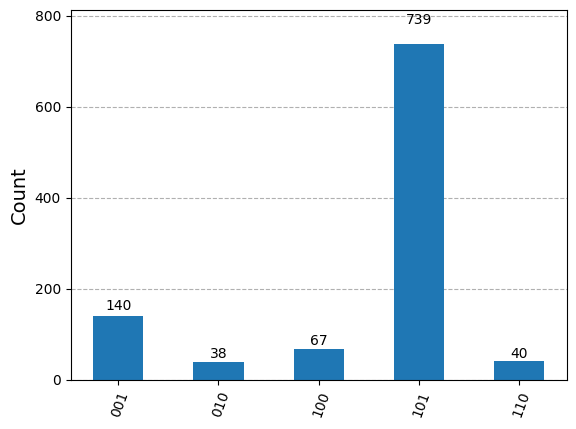

In [12]:
#sample implementation
#example state |101>
n= 3
qc= QuantumCircuit(n)
qc.x(0)
qc.x(2)

#append QFT and IQFT as instructions
qft_gate = qft(n).to_instruction()
iqft_gate = iqft(n).to_instruction()

qc.append(qft_gate, range(n))
qc.append(iqft_gate, range(n))

qc.measure_all()

#unroll the circuit to the simulator's basis gates
unrolled_qc = qc.decompose()


result= sim.run(unrolled_qc).result()
counts= result.get_counts()
plot_histogram(counts)

In [13]:
#Phase Estimation
#Quantum Phase Estimation(QPE) is an algorithm to estimate the phase theta in an eigenvalue of a unitary operator
#Problem Setup:
#given a unitary operator U, its eigenvector |Psi> with eigenvalue e^2*pi*i*theta
#goal is to estimate theta(unknown phase)

In [16]:
#QPE Implementation

def qpe(theta, t=3):

    qc = QuantumCircuit(t + 1, t)  #t qubits for phase, 1 for eigenstate
    #increase number of qubits for better precision

    #initialize eigenstate to |1>
    qc.x(t)

    #apply Hadamard to phase estimation register
    qc.h(range(t))

    #apply controlled-U^{2^j} = controlled-Rz(2pi * 2^j * theta)
    for j in range(t):
        angle = 2 * np.pi * theta * (2 ** j)
        qc.cp(angle, j, t)

    #apply IQFT to first t qubits

    qc.append(iqft(t), range(t)) #use the globally defined iqft function

    #measure phase register
    qc.measure(range(t), range(t))

    return qc

Counter({'001': 2763, '011': 567, '111': 298, '101': 162, '000': 147, '010': 65, '100': 49, '110': 45})


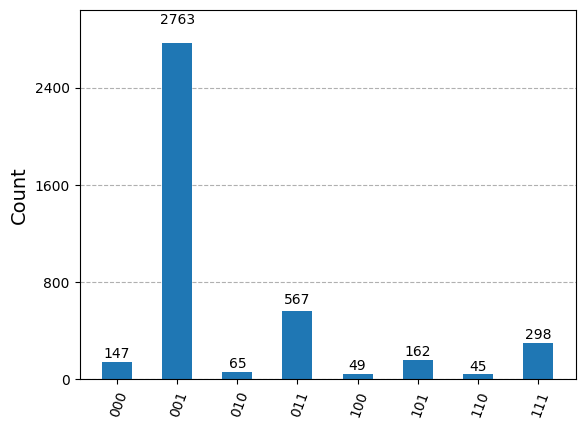

In [17]:
#define the phase theta
theta= 1/8

qpe_circuit= qpe(theta, t=3)

#run on sampler
isa_qc= pm.run(qpe_circuit)
result= sampler.run([isa_qc]).result()
pub_result= result[0]

#access the bitstrings from the 'c' attribute of the DataBin
bitstrings_data= pub_result.data.c

#convert the bitstrings to a list of binary strings by accessing the internal array
binary_strings= [bin(int.from_bytes(x, byteorder='big'))[2:].zfill(bitstrings_data.num_bits) for x in bitstrings_data._array]

#count the occurrences of each binary string
counts= Counter(binary_strings)

print(counts)
plot_histogram(counts)

In [18]:
#Shor's implementation

In [19]:

#helper function- GCD
def is_coprime(a, N):
    return gcd(a, N) == 1

#helper function- modular inverse finder
def get_order(a, N):
    for r in range(1, N):
        if pow(a, r, N) == 1:
            return r
    return None

#modular exponentiation unitary
def controlled_modular_exponentiation(a, N, power, n):
    qc = QuantumCircuit(n + len(bin(N)) - 2)
    for i in range(power):
        qc.cx(i, i)  # Placeholder: use modular exponentiation logic-- check!
    return qc

#basic modular QPE
def modular_qpe(a, N, n_count=8):
    n = n_count
    qc = QuantumCircuit(n + len(bin(N)) - 2, n)

    #prepare counting qubits in |+> state
    for q in range(n):
        qc.h(q)

    #prepare eigenvector |1> (non-trivial in real case)
    qc.x(n)

    for q in range(n):
        qc.append(controlled_modular_exponentiation(a, N, 2**q, n), list(range(n + len(bin(N)) - 2)))

    qc.append(qft(n), range(n))
    qc.measure(range(n), range(n))
    return qc


In [20]:
#classical post-processing
def classical_postprocessing(measured_phase, N, a):
    theta = measured_phase / (2 ** len(measured_phase))
    frac = Fraction(theta).limit_denominator(N)
    r = frac.denominator

    if r % 2 != 0 or pow(a, r, N) == 1:
        return None

    x = pow(a, r // 2, N)
    factor1 = gcd(x - 1, N)
    factor2 = gcd(x + 1, N)

    if factor1 in [1, N] or factor2 in [1, N]:
        return None

    return factor1, factor2



In [21]:
#Shor's main function
def shors(N):
    while True:
        a = randint(2, N)
        if gcd(a, N) != 1:
            return gcd(a, N), N // gcd(a, N)

        qc= modular_qpe(a, N)
        transpiled = transpile(qc, backend)
        result= sim.run(transpiled, shots=1024).result()
        counts= result.get_counts()

        #most frequent result
        measured= max(counts, key=counts.get)
        measured_int= int(measured, 2)

        if measured_int == 0:
            continue

        factor_pair= classical_postprocessing(measured, N, a)
        if factor_pair:
            return factor_pair

In [27]:
#example- factoring 16
factors= shors(16)
print("Factors:", factors)


Factors: (2, 8)


In [25]:
factors= shors(21)
print("Factors:", factors)

Factors: (7, 3)
